We organized the KDD cup 2009 around a marketing problem with the goal of identifying data mining techniques capable of rapidly building predictive models and scoring new
entries on a large database. Customer Relationship Management (CRM) is a key element of modern marketing strategies. The KDD Cup 2009 offered to participants an opportunity to work on a large marketing database from the
French Telecom company Orange. The tasks were to predict
the propensity of customers to switch provider (churn), buy
new products or services (appetency), or buy upgrades/addons proposed to them to make the sale more profitable (upselling). The challenge, which lasted from March 10 to
May 11, 2009, attracted over 450 participants from 46 countries. We attribute its popularity to several factors: (1)
A generic problem relevant to the Industry (a classification problem), but presenting a number of scientific and
technical challenges, including many missing values (about
60%), a large number of features (15000) and a large number of training examples (50000), unbalanced class proportions (fewer than 10% of the examples of the positive class),
noisy data, and the presence of categorical variables with
many different values. (2) Prizes (Orange offers 10000 Euros in prizes). (3) A well designed protocol and web site
(we benefitted from past experience). (4) An effective advertising campaign using mailings and a teleconference to
answer potential participants questions. The results of the
challenge were discussed at the KDD conference (June 28,
2009). The principal conclusions are that ensemble methods are very effective and that ensemble of decision trees
offer off-the-shelf solutions to problems with large numbers
of samples and attributes, mixed types of variables, and lots
of missing values. The data and the platform of the challenge remain available for research and educational purposes
at http://www.kddcup-orange.com/.

## https://www.kdd.org/exploration_files/v11-2-12-KDDCUP09_analysis.pdf

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support,roc_auc_score)
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score,auc
from sklearn.model_selection import RandomizedSearchCV
import math
import xgboost as xgb

Using TensorFlow backend.


In [6]:
import os
print(os.listdir("../input"))

['kdd2009', 'dlcvpdf']


In [7]:
train = pd.read_table('../input/kdd2009/orange_small_train.data')
train.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
0,NaN,NaN,NaN,NaN,NaN,1526.0,7.0,NaN,NaN,NaN,...,oslk,fXVEsaq,jySVZNlOJy,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,525.0,0.0,NaN,NaN,NaN,...,oslk,2Kb5FSF,LM8l689qOp,NaN,NaN,fKCe,RAYp,F2FyR07IdsN7I,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,5236.0,7.0,NaN,NaN,NaN,...,Al6ZaUT,NKv4yOc,jySVZNlOJy,NaN,kG3k,Qu4f,02N6s8f,ib5G6X1eUxUn6,am7c,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,oslk,CE7uk3u,LM8l689qOp,NaN,NaN,FSa2,RAYp,F2FyR07IdsN7I,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,1029.0,7.0,NaN,NaN,NaN,...,oslk,1J2cvxe,LM8l689qOp,NaN,kG3k,FSa2,RAYp,F2FyR07IdsN7I,mj86,NaN


Upselling Prediction****

In [8]:
target_upselling = pd.read_csv('../input/kdd2009/upselling.csv', header=None)
target_upselling.columns = ["labels"]
target_upselling = (target_upselling + 1)/2

# Missing Values

In [9]:
train.isnull().sum(axis = 0)/len(train)

Var1      0.98596
Var2      0.97518
Var3      0.97520
Var4      0.96842
Var5      0.97026
Var6      0.11058
Var7      0.11078
Var8      1.00000
Var9      0.98596
Var10     0.97026
Var11     0.97520
Var12     0.98884
Var13     0.11078
Var14     0.97520
Var15     1.00000
Var16     0.97026
Var17     0.96842
Var18     0.96842
Var19     0.96842
Var20     1.00000
Var21     0.11058
Var22     0.10018
Var23     0.97026
Var24     0.14460
Var25     0.10018
Var26     0.97026
Var27     0.97026
Var28     0.10022
Var29     0.98596
Var30     0.98596
           ...   
Var201    0.74434
Var202    0.00002
Var203    0.00286
Var204    0.00000
Var205    0.03868
Var206    0.11058
Var207    0.00000
Var208    0.00286
Var209    1.00000
Var210    0.00000
Var211    0.00000
Var212    0.00000
Var213    0.97742
Var214    0.50816
Var215    0.98612
Var216    0.00000
Var217    0.01406
Var218    0.01406
Var219    0.10422
Var220    0.00000
Var221    0.00000
Var222    0.00000
Var223    0.10422
Var224    0.98360
Var225    

In [10]:
for i,j in enumerate(train.isnull().sum(axis = 0)/len(train)):
    if j>=1:
        train = train.drop(["Var" + str(i+1)], axis = 1)

In [11]:
# https://stackoverflow.com/questions/25239958/impute-categorical-missing-values-in-scikit-learn
from sklearn.base import TransformerMixin

class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series(["missing"
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

In [12]:
imp = DataFrameImputer().fit(train)
train = imp.transform(train)

In [13]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

for i in range(0,train.shape[1]):
    if train.dtypes[i]=='object':
        train[train.columns[i]] = le.fit_transform(train[train.columns[i]])

In [14]:
train.shape

(50000, 212)

In [15]:
target_upselling.shape

(50000, 1)

In [16]:
train.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var9,Var10,Var11,...,Var220,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229
0,11.487179,0.004029,425.298387,0.125396,238793.32885,1526.000000,7.0,48.145299,392605.656355,8.625806,...,94,4,2964,3,1,2,22,2,8,1
1,11.487179,0.004029,425.298387,0.125396,238793.32885,525.000000,0.0,48.145299,392605.656355,8.625806,...,10,4,125,0,1,2,14,2,8,1
2,11.487179,0.004029,425.298387,0.125396,238793.32885,5236.000000,7.0,48.145299,392605.656355,8.625806,...,1293,0,1610,3,1,1,10,0,25,0
3,11.487179,0.004029,425.298387,0.125396,238793.32885,1326.437116,0.0,48.145299,392605.656355,8.625806,...,1444,4,817,0,1,2,7,2,8,1
4,11.487179,0.004029,425.298387,0.125396,238793.32885,1029.000000,7.0,48.145299,392605.656355,8.625806,...,1731,4,65,0,1,1,7,2,8,2


In [17]:
X_train, X_test, y_train, y_test = train_test_split(train,target_upselling ,test_size=0.2, random_state=42)

In [18]:
# prepare the scaler with train data
scaler = StandardScaler(with_mean=False).fit(X_train)
# transform both train and test data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [34]:
X_train = preprocessing.scale(X_train)
X_test = preprocessing.scale(X_test)

# Random Forest

In [35]:
tuned_parameters = {
'max_depth' : [3,5,8],
'n_estimators': [300, 500],
'min_samples_split' :[10,15],
'min_samples_leaf' : [1, 2, 5, 10]}
# Instantiate a logistic regression classifier: logreg
rfc=RandomForestClassifier(random_state=1, class_weight="balanced")


# Instantiate the GridSearchCV object: logreg_cv

param_comb = 10
rfc_cv = RandomizedSearchCV(rfc, param_distributions=tuned_parameters, n_iter=param_comb, scoring="roc_auc", n_jobs=-1, cv=3, verbose=10, random_state=1 )


# Fit it to the data
rfc_cv.fit(X_train, y_train)

# Print the tuned parameter and score
print("Tuned Parameters: {}".format(rfc_cv.best_params_))
print("Best score is {}".format(rfc_cv.best_score_))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:  7.0min remaining:   46.6s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  7.7min finished


Tuned Parameters: {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 8}
Best score is 0.9029174547330732


In [36]:
#clf.fit(X_train, y_train)
predictions = rfc_cv.predict(X_test)

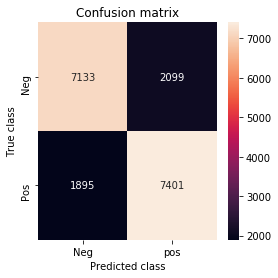

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%matplotlib inline
#Gerando Matriz de Confusão
conf_matrix = confusion_matrix(y_test, predictions)
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix,  annot=True,xticklabels=['Neg','pos'], yticklabels=['Neg','Pos'],fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [38]:
roc_auc_score(y_test, predictions)

0.7843937647097426

# XGB

In [163]:
from sklearn.model_selection import RandomizedSearchCV
#import timer
import math
import xgboost as xgb


# A parameter grid for XGBoost
params = {
        'n_estimators': [100,300,500],
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3,5]
        }

# scale_pos_weight = np.sum(y == 1)/ float(np.sum(y == 0))
# sum(negative instances) / sum(positive instances)
xgb_random = xgb.XGBClassifier(learning_rate=0.02, scale_pos_weight=12.6)


param_comb = 5
random_search = RandomizedSearchCV(xgb_random, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=-1, cv=3, verbose=5, random_state=1 )

random_search.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:  2.3min remaining:   35.0s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  4.5min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.02, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=...
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid='warn', n_iter=5, n_jobs=-1,
                   param_distribu

In [164]:
predictions = random_search.predict(X_test)

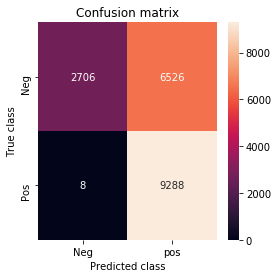

In [165]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%matplotlib inline
#Gerando Matriz de Confusão
conf_matrix = confusion_matrix(y_test, predictions)
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix,  annot=True,xticklabels=['Neg','pos'], yticklabels=['Neg','Pos'],fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [166]:
roc_auc_score(y_test, predictions)

0.6461251666731298

# Neural Network with Imbalanced Dataset

## Applying SMOTE

In [43]:
sm = SMOTE(sampling_strategy='auto')
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

In [44]:
print('After OverSampling, the shape of X_train: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of y_train: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

After OverSampling, the shape of X_train: (74172, 212)
After OverSampling, the shape of y_train: (74172,) 

After OverSampling, counts of label '1': 37086
After OverSampling, counts of label '0': 37086


In [45]:
X_train = preprocessing.scale(X_train)
X_test = preprocessing.scale(X_test)

In [46]:
from keras.models import Sequential
from keras.layers import Dense, Activation

In [47]:
import tensorflow as tf
# define roc_callback, inspired by https://github.com/keras-team/keras/issues/6050#issuecomment-329996505
def auc_roc(y_true, y_pred):
    # any tensorflow metric
    value, update_op = tf.contrib.metrics.streaming_auc(y_pred, y_true)

    # find all variables created for this metric
    metric_vars = [i for i in tf.local_variables() if 'auc_roc' in i.name.split('/')[1]]

    # Add metric variables to GLOBAL_VARIABLES collection.
    # They will be initialized for new session.
    for v in metric_vars:
        tf.add_to_collection(tf.GraphKeys.GLOBAL_VARIABLES, v)

    # force to update metric values
    with tf.control_dependencies([update_op]):
        value = tf.identity(value)
        return value

In [48]:
# some model parameters
output_dim = 1
input_dim = X_train_res.shape[1]
batch_size = 128
nb_epoch = 20

In [49]:
# input-256-120-output
from keras.layers import Dropout
from keras.layers.normalization import BatchNormalization
# Multilayer perceptron
from keras import regularizers
model_relu = Sequential()
model_relu.add(Dense(128, activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01), input_shape=(input_dim,)))
model_relu.add(BatchNormalization())
#model_relu.add(Dropout(0.3))
model_relu.add(Dense(64, activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01), input_shape=(input_dim,)))
model_relu.add(BatchNormalization())
#model_relu.add(Dropout(0.3))
model_relu.add(Dense(32, activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01)))
model_relu.add(BatchNormalization())
#model_relu.add(Dropout(0.3))
model_relu.add(Dense(16, activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01), input_shape=(input_dim,)))
model_relu.add(BatchNormalization())
#model_relu.add(Dropout(0.3))
model_relu.add(Dense(8, activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01), input_shape=(input_dim,)))
model_relu.add(BatchNormalization())
#model_relu.add(Dropout(0.3))
model_relu.add(Dense(output_dim, activation='sigmoid'))

model_relu.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 128)               27264     
_________________________________________________________________
batch_normalization_6 (Batch (None, 128)               512       
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
batch_normalization_7 (Batch (None, 64)                256       
_________________________________________________________________
dense_9 (Dense)              (None, 32)                2080      
_________________________________________________________________
batch_normalization_8 (Batch (None, 32)                128       
_________________________________________________________________
dense_10 (Dense)             (None, 16)                528       
__________

In [50]:
model_relu.compile(optimizer='adam', loss='binary_crossentropy', metrics=[auc_roc])
history = model_relu.fit(X_train_res, y_train_res, batch_size=batch_size, epochs=nb_epoch, verbose=1,validation_data=(X_test, y_test))

Train on 74172 samples, validate on 18528 samples
Epoch 1/20
74172/74172 [==============================] - 7s 92us/step - loss: 2.1883 - auc_roc: 0.7329 - val_loss: 0.9407 - val_auc_roc: 0.8111
Epoch 2/20
74172/74172 [==============================] - 4s 50us/step - loss: 0.6860 - auc_roc: 0.8279 - val_loss: 0.6115 - val_auc_roc: 0.8399
Epoch 3/20
74172/74172 [==============================] - 4s 51us/step - loss: 0.5549 - auc_roc: 0.8476 - val_loss: 0.5630 - val_auc_roc: 0.8533
Epoch 4/20
74172/74172 [==============================] - 5s 62us/step - loss: 0.5233 - auc_roc: 0.8585 - val_loss: 0.5493 - val_auc_roc: 0.8631
Epoch 5/20
74172/74172 [==============================] - 5s 62us/step - loss: 0.5062 - auc_roc: 0.8676 - val_loss: 0.5577 - val_auc_roc: 0.8714
Epoch 6/20
74172/74172 [==============================] - 4s 57us/step - loss: 0.4967 - auc_roc: 0.8752 - val_loss: 0.5462 - val_auc_roc: 0.8786
Epoch 7/20
74172/74172 [==============================] - 4s 59us/step - loss: 0

In [51]:
predictions = model_relu.predict_classes(X_test)

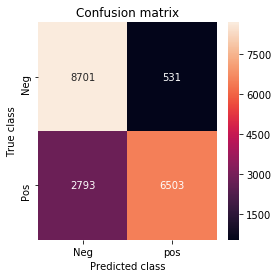

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%matplotlib inline
#Gerando Matriz de Confusão
conf_matrix = confusion_matrix(y_test, predictions)
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix,  annot=True,xticklabels=['Neg','pos'], yticklabels=['Neg','Pos'],fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [53]:
roc_auc_score(y_test, predictions)

0.8210154308742771

# Upsampling of minority class

In [150]:
# https://elitedatascience.com/imbalanced-classes
train_comb = pd.concat([train,target_upselling], axis=1)

# Separate majority and minority classes
df_majority = train_comb[train_comb['labels']==0]
df_minority = train_comb[train_comb['labels']==1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=df_majority.shape[0],    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled['labels'].value_counts()

1    46318
0    46318
Name: labels, dtype: int64

In [151]:
target = df_upsampled['labels']
df_upsampled = df_upsampled.drop('labels', axis=1)

In [152]:
for i,j in enumerate(df_upsampled.isnull().sum(axis = 0)/len(df_upsampled)):
    if j>=1:
        df_upsampled = df_upsampled.drop(["Var" + str(i+1)], axis = 1)

In [153]:
imp = DataFrameImputer().fit(df_upsampled)
df_upsampled = imp.transform(df_upsampled)

In [154]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

for i in range(0,df_upsampled.shape[1]):
    if df_upsampled.dtypes[i]=='object':
        df_upsampled[df_upsampled.columns[i]] = le.fit_transform(df_upsampled[df_upsampled.columns[i]])

In [155]:
X_train, X_test, y_train, y_test = train_test_split(df_upsampled,target,test_size=0.2, random_state=42)

# Neural Network

In [156]:
# some model parameters
output_dim = 1
input_dim = X_train.shape[1]
batch_size = 128
nb_epoch = 20

In [157]:
X_train = preprocessing.scale(X_train)
X_test = preprocessing.scale(X_test)

In [158]:
# input-256-120-output
from keras.layers import Dropout
from keras.layers.normalization import BatchNormalization
# Multilayer perceptron
from keras import regularizers
model_relu = Sequential()
model_relu.add(Dense(128, activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01), input_shape=(input_dim,)))
model_relu.add(BatchNormalization())
model_relu.add(Dropout(0.2))
model_relu.add(Dense(64, activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01), input_shape=(input_dim,)))
model_relu.add(BatchNormalization())
model_relu.add(Dropout(0.2))
model_relu.add(Dense(32, activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01)))
model_relu.add(BatchNormalization())
model_relu.add(Dropout(0.2))
model_relu.add(Dense(16, activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01), input_shape=(input_dim,)))
model_relu.add(BatchNormalization())
model_relu.add(Dropout(0.2))
model_relu.add(Dense(8, activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01), input_shape=(input_dim,)))
model_relu.add(BatchNormalization())
model_relu.add(Dropout(0.2))
model_relu.add(Dense(output_dim, activation='sigmoid'))

model_relu.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_61 (Dense)             (None, 128)               27264     
_________________________________________________________________
batch_normalization_51 (Batc (None, 128)               512       
_________________________________________________________________
dropout_46 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_62 (Dense)             (None, 64)                8256      
_________________________________________________________________
batch_normalization_52 (Batc (None, 64)                256       
_________________________________________________________________
dropout_47 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_63 (Dense)             (None, 32)                2080      
__________

In [159]:
model_relu.compile(optimizer='adam', loss='binary_crossentropy', metrics=[auc_roc])
history = model_relu.fit(X_train, y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1,validation_data=(X_test, y_test))

Train on 74108 samples, validate on 18528 samples
Epoch 1/20
74108/74108 [==============================] - 14s 193us/step - loss: 2.3003 - auc_roc: 0.6368 - val_loss: 0.8901 - val_auc_roc: 0.7360
Epoch 2/20
74108/74108 [==============================] - 7s 88us/step - loss: 0.6587 - auc_roc: 0.7674 - val_loss: 0.5861 - val_auc_roc: 0.7875
Epoch 3/20
74108/74108 [==============================] - 7s 92us/step - loss: 0.5592 - auc_roc: 0.7992 - val_loss: 0.5537 - val_auc_roc: 0.8076
Epoch 4/20
74108/74108 [==============================] - 8s 105us/step - loss: 0.5463 - auc_roc: 0.8141 - val_loss: 0.5510 - val_auc_roc: 0.8195
Epoch 5/20
74108/74108 [==============================] - 7s 91us/step - loss: 0.5444 - auc_roc: 0.8240 - val_loss: 0.5423 - val_auc_roc: 0.8277
Epoch 6/20
74108/74108 [==============================] - 7s 99us/step - loss: 0.5370 - auc_roc: 0.8311 - val_loss: 0.5205 - val_auc_roc: 0.8343
Epoch 7/20
74108/74108 [==============================] - 7s 96us/step - loss

In [160]:
predictions = model_relu.predict_classes(X_test)

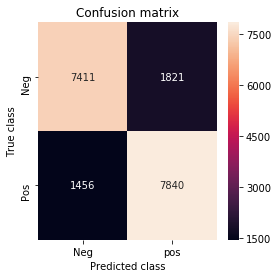

In [161]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%matplotlib inline
#Gerando Matriz de Confusão
conf_matrix = confusion_matrix(y_test, predictions)
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix,  annot=True,xticklabels=['Neg','pos'], yticklabels=['Neg','Pos'],fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [162]:
roc_auc_score(y_test, predictions)

0.8230623969012967

# Conclusion

In [167]:
from prettytable import PrettyTable
x = PrettyTable()

x.field_names = ["Model", "Test Score"]
x.add_row(["RF with class weight balanced", 0.7843937647097426])
x.add_row(["xgb", 0.6461251666731298])
x.add_row(["SMOTE with Neural Network", 0.8210154308742771])
x.add_row(["upsampling with Neural Network", 0.8230623969012967])
print(x)

+--------------------------------+--------------------+
|             Model              |     Test Score     |
+--------------------------------+--------------------+
| RF with class weight balanced  | 0.7843937647097426 |
|              xgb               | 0.6461251666731298 |
|   SMOTE with Neural Network    | 0.8210154308742771 |
| upsampling with Neural Network | 0.8230623969012967 |
+--------------------------------+--------------------+
